<a href="https://colab.research.google.com/github/Akhilrajeevp/BOOK-TEXT-VISUALISER/blob/main/BOOK_TEXT_VISUALISER_(CLIP_Guided_Diffusion_HQ_256x256_%2BNLP_model_created_for_text_to_image_conversion).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check the GPU status
!nvidia-smi

Tue Jul  4 05:04:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install dependencies

!git clone https://github.com/openai/CLIP
!git clone https://github.com/crowsonkb/guided-diffusion
!pip install -e ./CLIP
!pip install -e ./guided-diffusion
!pip install lpips

Cloning into 'CLIP'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 8.92 MiB | 17.54 MiB/s, done.
Resolving deltas: 100% (123/123), done.
Cloning into 'guided-diffusion'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 105 (delta 0), reused 1 (delta 0), pack-reused 102
Receiving objects: 100% (105/105), 61.63 KiB | 270.00 KiB/s, done.
Resolving deltas: 100% (54/54), done.
Obtaining file:///content/CLIP
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.2 MB/s eta 0:00:00
  Running setup.py develop for clip
Obtaining file:///content/guided-diffusion
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 82.2 MB/s eta 0:00:00


In [3]:
# Download the diffusion model

!curl -OL 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2108M  100 2108M    0     0  9632k      0  0:03:44  0:03:44 --:--:-- 9950k


In [4]:
# Imports

import gc
import io
import math
import sys

from IPython import display
import lpips
from PIL import Image
import requests
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm

sys.path.append('./CLIP')
sys.path.append('./guided-diffusion')

import clip
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults

In [5]:
# Define necessary functions

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')


def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)


def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


def range_loss(input):
    return (input - input.clamp(-1, 1)).pow(2).mean([1, 2, 3])

In [6]:
# Model settings

model_config = model_and_diffusion_defaults()
model_config.update({
    'attention_resolutions': '32, 16, 8',
    'class_cond': False,
    'diffusion_steps': 1000,
    'rescale_timesteps': True,
    'timestep_respacing': '1000',  # Modify this value to decrease the number of
                                   # timesteps.
    'image_size': 256,
    'learn_sigma': True,
    'noise_schedule': 'linear',
    'num_channels': 256,
    'num_head_channels': 64,
    'num_res_blocks': 2,
    'resblock_updown': True,
    'use_checkpoint': False,
    'use_fp16': True,
    'use_scale_shift_norm': True,
})

In [7]:
# Load models

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load('256x256_diffusion_uncond.pt', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
if model_config['use_fp16']:
    model.convert_to_fp16()

clip_model = clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device)
clip_size = clip_model.visual.input_resolution
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])
lpips_model = lpips.LPIPS(net='vgg').to(device)


Using device: cuda:0


100%|████████████████████████████████████████| 335M/335M [00:01<00:00, 322MiB/s]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 263MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


## Settings for this run:

In [12]:
import spacy

nlp = spacy.load('en_core_web_sm')
text ="A centuries-old vampire and Transylvanian nobleman. He inhabits a crumbling castle in the Carpathian Mountains1. He is described as a tall old man with a long white mustache2. He is clothed entirely in black"
doc = nlp(text)


prompts = [chunk.text for chunk in doc.noun_chunks]
for prompt in prompts:
    image_prompts = []
    batch_size = 1
    clip_guidance_scale = 1000  # Controls how much the image should look like the prompt.
    tv_scale = 150              # Controls the smoothness of the final output.
    range_scale = 50            # Controls how far out of range RGB values are allowed to be.
    cutn = 16
    n_batches = 1
    init_image = None   # This can be an URL or Colab local path and must be in quotes.
    skip_timesteps = 0  # This needs to be between approx. 200 and 500 when using an init image.
                    # Higher values make the output look more like the init.
    init_scale = 0      # This enhances the effect of the init image, a good value is 1000.
    seed = 0



### Actually do the run...

  0%|          | 0/1000 [00:00<?, ?it/s]


Batch 0, step 0, output 0:


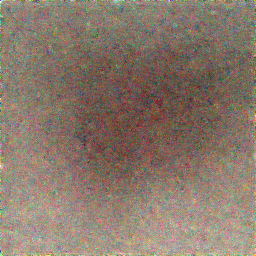


Batch 0, step 100, output 0:


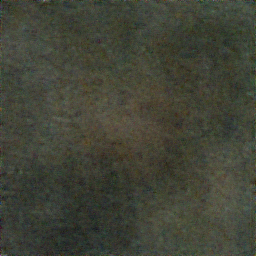


Batch 0, step 200, output 0:


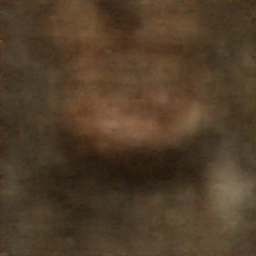


Batch 0, step 300, output 0:


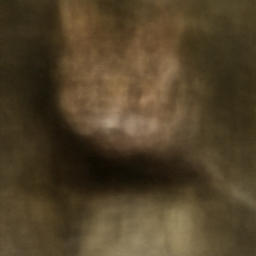


Batch 0, step 400, output 0:


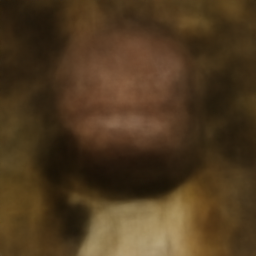


Batch 0, step 500, output 0:


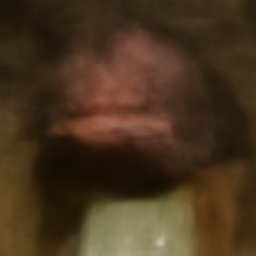


Batch 0, step 600, output 0:


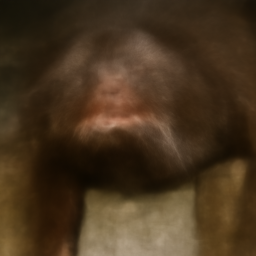


Batch 0, step 700, output 0:


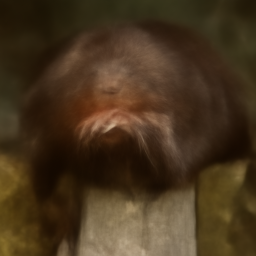


Batch 0, step 800, output 0:


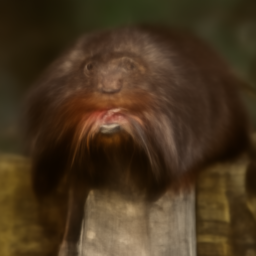


Batch 0, step 900, output 0:


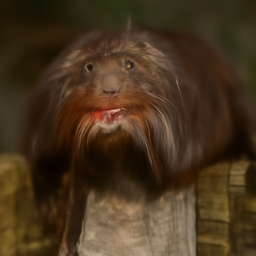


Batch 0, step 999, output 0:


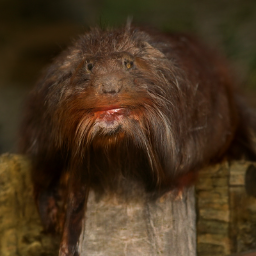

In [11]:
def do_run():
    if seed is not None:
        torch.manual_seed(seed)

    make_cutouts = MakeCutouts(clip_size, cutn)
    side_x = side_y = model_config['image_size']

    target_embeds, weights = [], []

    for prompt in prompts:
        txt, weight = parse_prompt(prompt)
        target_embeds.append(clip_model.encode_text(clip.tokenize(txt).to(device)).float())
        weights.append(weight)

    for prompt in image_prompts:
        path, weight = parse_prompt(prompt)
        img = Image.open(fetch(path)).convert('RGB')
        img = TF.resize(img, min(side_x, side_y, *img.size), transforms.InterpolationMode.LANCZOS)
        batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
        embed = clip_model.encode_image(normalize(batch)).float()
        target_embeds.append(embed)
        weights.extend([weight / cutn] * cutn)

    target_embeds = torch.cat(target_embeds)
    weights = torch.tensor(weights, device=device)
    if weights.sum().abs() < 1e-3:
        raise RuntimeError('The weights must not sum to 0.')
    weights /= weights.sum().abs()

    init = None
    if init_image is not None:
        init = Image.open(fetch(init_image)).convert('RGB')
        init = init.resize((side_x, side_y), Image.LANCZOS)
        init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)

    cur_t = None

    def cond_fn(x, t, out, y=None):
        n = x.shape[0]
        fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
        x_in = out['pred_xstart'] * fac + x * (1 - fac)
        clip_in = normalize(make_cutouts(x_in.add(1).div(2)))
        image_embeds = clip_model.encode_image(clip_in).float()
        dists = spherical_dist_loss(image_embeds.unsqueeze(1), target_embeds.unsqueeze(0))
        dists = dists.view([cutn, n, -1])
        losses = dists.mul(weights).sum(2).mean(0)
        tv_losses = tv_loss(x_in)
        range_losses = range_loss(out['pred_xstart'])
        loss = losses.sum() * clip_guidance_scale + tv_losses.sum() * tv_scale + range_losses.sum() * range_scale
        if init is not None and init_scale:
            init_losses = lpips_model(x_in, init)
            loss = loss + init_losses.sum() * init_scale
        return -torch.autograd.grad(loss, x)[0]

    if model_config['timestep_respacing'].startswith('ddim'):
        sample_fn = diffusion.ddim_sample_loop_progressive
    else:
        sample_fn = diffusion.p_sample_loop_progressive

    for i in range(n_batches):
        cur_t = diffusion.num_timesteps - skip_timesteps - 1

        samples = sample_fn(
            model,
            (batch_size, 3, side_y, side_x),
            clip_denoised=False,
            model_kwargs={},
            cond_fn=cond_fn,
            progress=True,
            skip_timesteps=skip_timesteps,
            init_image=init,
            randomize_class=True,
            cond_fn_with_grad=True,
        )

        for j, sample in enumerate(samples):
            cur_t -= 1
            if j % 100 == 0 or cur_t == -1:
                print()
                for k, image in enumerate(sample['pred_xstart']):
                    filename = f'progress_{i * batch_size + k:05}.png'
                    TF.to_pil_image(image.add(1).div(2).clamp(0, 1)).save(filename)
                    tqdm.write(f'Batch {i}, step {j}, output {k}:')
                    display.display(display.Image(filename))

gc.collect()
do_run()